El caso de uso más común de las redes neuronales es para procesar información **desestructurada** que no es tan sencilla o eficiente de procesar con algoritmos tradicionales.
Este es el caso de, por ejemplo, la información contenida en imágenes o texto.

Hay varias arquitecturas de redes neuronales que son muy comúnmente usadas para cada tipo de problema en específico (convolucionales para imágenes, y LSTM para texto), pero,
como son conceptos muy avanzados, aquí nos vamos a centrar en el preprocesamiento de las imágenes para introducirlas a un algoritmo.

# Preprocesado de imágenes

El preprocesado de imágenes se basa, en general, en intentar transformar las imágenes de tal forma que omitamos la mayor cantidad posible de píxeles que no aportan información
de cara al modelo. La forma de pensarlo es similar a cómo, con un dataset normal, hacíamos un preprocesamiento de esas variables (escalado, transformaciones, feature engineering...)
para obtener de ellas información más relevante de cara al problema que queremos resolver.

## Escala de grises

Muy a menudo nos convendrá convertir las imágenes a escala de grises, ya que así nos ahorramos información sobre el color que no nos es relevante. Esto depende del problema, claro;
si el color es de alguna forma importante en la imagen, es fundamental incorporarlo.

Podemos convertir una imagen a escala de grises con el método `rgb2gray`.

In [1]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2gray
from skimage import io

original = data.astronaut()
grayscale = rgb2gray(original)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'skimage'

## Corrección del gamma

Esta técnica nos permite ajustar la visibilidad de imágenes que se vean demasiado oscuras. Ajustarlas demasiado puede volverlas demasiado brillantes e inútiles para el preprocesado.
Hay que encontrar un punto medio.

La corrección de gamma con `skimage` se puede realizar con el método `exposure`.

Es particularmente útil el método `match_histograms`, que nos permite igualar los contrastes de todas las imágenes al de una de referencia.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Gamma
gamma_corrected = exposure.adjust_gamma(img, 2)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

Es

## Filtros

Hay unos cuantos filtros que podemos usar para poder simplificar la imagen y mejorar el desempeño de nuestro modelo. Vienen incluidos en el módulo [`skimage.filters`](https://scikit-image.org/docs/stable/api/skimage.filters.html). A continuación ponemos algunos ejemplos:

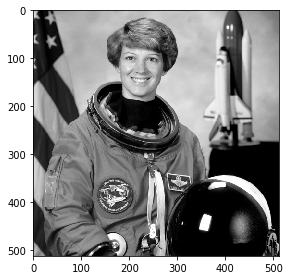

In [ ]:
from skimage.color import rgb2gray

# Pasamos a escala de grises porque muchos filtros están preparados para
# funcionar con imágenes así.
astronaut = data.astronaut()
astronaut = rgb2gray(astronaut)
io.imshow(astronaut)

El filtro [`gaussian`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian) permite desenfocar las imágenes:

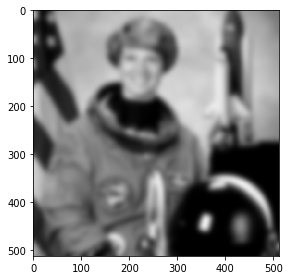

In [ ]:
from skimage import filters

sigma = 5.5  #@param {type: "slider", min: 0, max: 10, step:0.5}
io.imshow(filters.gaussian(astronaut, sigma=sigma))

El filtro [`unsharp_mask`](https://scikit-image.org/docs/stable/api/skimage.filters.html#unsharp-mask) permite resaltar los bordes de la imagen y desenfocar las zonas sin bordes:

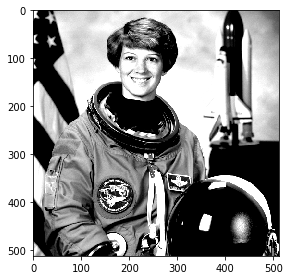

In [ ]:
radius = 98.5  #@param {type:"slider", min:0.5, max:100, step:0.5}
io.imshow(filters.unsharp_mask(astronaut, radius=radius))

El filtro [`median`](https://scikit-image.org/docs/stable/api/skimage.filters.html#median) "aplana" una imagen calculando el valor medio local de cada pixel:

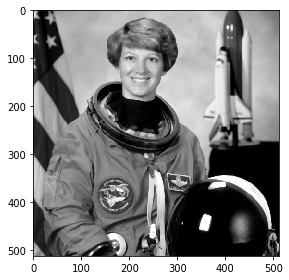

In [ ]:
io.imshow(filters.median(astronaut))

Hay unos cuantos más que animo a mirar y experimentar con ellos; como puedes ver, todos los métodos se usan de forma muy similar.

## Transformaciones

De manera similar a los filtros, las transformaciones nos permiten centrarnos en la información relevante de las imágenes. En el módulo `skimage` están todas las que te esperarías: rotación, reajuste del tamaño, del escalado, reducción de píxeles... Algunos ejemplos:

In [ ]:
from skimage import transform, data

# Rotar la imagen 45 grados en sentido antihorario
rotated = transform.rotate(astronaut, angle=45)
io.imshow(rotated)

In [ ]:
# Escalar la imagen a la mitad de su tamaño original
scaled = transform.rescale(astronaut, 0.5)
io.imshow(scaled)

In [ ]:
# Definir una matriz de transformación afín
tform = transform.AffineTransform(scale=(1.2, 1.2), rotation=0.2, translation=(50, -10))
transformed = transform.warp(image, tform)
io.imshow(transformed)